# Install packages


In [1]:
!pip install transformers
!pip install datasets
!pip install keras-tuner

# Import libraries

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import keras_tuner as kt
#from google.colab import drive
import sys

# Import tokenizer and pre-trained model

In [3]:
#tokenizer: https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model
#switched from BertTokenizer and TFBertForSequenceClassification to DistilBert...
#... because it was taking hours locally (eventually crashed my computer)...
#... and maxing out free Google Colab RAM. Now it takes about 30 minutes locally and 2 hours in Colab.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

# Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Random Seed

In [4]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Load data

In [5]:
import pandas as pd

# Load the raw training data
df_raw_train = pd.read_csv("data/train.csv")
# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)

# Load the raw test data
df_raw_test = pd.read_csv("data/test.csv")
# Make a copy of df_raw_test
df_test = df_raw_test.copy(deep=True)

# Get the name of the target
target = 'target'


In [6]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,7613,5


In [7]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,3263,4


In [8]:
# Print the first 5 rows of df_train
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Print the first 5 rows of df_test
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Drop columns we don't need

In [10]:
#drop columns
df_train.drop(['id','keyword','location'],axis=1,inplace=True)
df_test.drop(['id','keyword','location'],axis=1,inplace=True)

In [11]:
# Print the first 5 rows of df_train to ensure dropping worked correctly
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
# Print the first 5 rows of df_test to ensure dropping worked correctly
df_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


# Split features and target

In [13]:
# Batch tokenize our tweet field
X_train = tokenizer.batch_encode_plus(df_train.text, pad_to_max_length=True, return_tensors="tf")
X_test = tokenizer.batch_encode_plus(df_test.text, pad_to_max_length=True, return_tensors="tf")

# Get our target
y_train = df_train['target'].to_numpy()


/Users/paulkelly/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Preparing for hyperparameter tuning

In [14]:
#Technique sourced from tensorflow documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner
#Create class to allow Keras Tuner to build the best model from our pre-defined options
def model_builder(hp):
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
    #optimal learning rates sourced from "BERT" paper: https://arxiv.org/abs/1810.04805
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-5, 3e-5, 4e-5, 5e-5])
    #AdamW optimizer instead of Adam: https://towardsdatascience.com/why-adamw-matters-736223f31b5d
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
                metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))
    
    return model

In [15]:
#Invoke Keras Tuner's Hyperband tuner.
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='ml_1',
                     project_name='final_project')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

# Tuning best learning rate with 80/20 train-val split

In [16]:
#Add early stop callback for the tuner search.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [18]:
#Begin tuning with learning rate
tuner.search(x=X_train['input_ids'], y=y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 4 Complete [00h 26m 12s]
val_accuracy: 0.8319107294082642

Best val_accuracy So Far: 0.8351936936378479
Total elapsed time: 01h 45m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal learning rate for the optimizer is 2e-05.



# Tuning best epoch with 80/20 train-val split

In [19]:
#Continue tuning for best epoch 
model = tuner.hypermodel.build(best_hps)
history = model.fit(x=X_train['input_ids'], y=y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
191/191 [==============================] - 787s 4s/step - loss: 0.4624 - accuracy: 0.7872 - val_loss: 0.3847 - val_accuracy: 0.8306
Epoch 2/10
191/191 [==============================] - 768s 4s/step - loss: 0.3462 - accuracy: 0.8624 - val_loss: 0.3918 - val_accuracy: 0.8345
Epoch 3/10
191/191 [==============================] - 768s 4s/step - loss: 0.2740 - accuracy: 0.8957 - val_loss: 0.4199 - val_accuracy: 0.8418
Epoch 4/10
191/191 [==============================] - 767s 4s/step - loss: 0.2153 - accuracy: 0.9232 - val_loss: 0.4744 - val_accuracy: 0.8155
Epoch 5/10
191/191 [==============================] - 780s 4s/step - loss: 0.1539 - accuracy: 0.9483 - val_loss: 0.5317 - val_accuracy: 0.8280
Epoch 6/10
191/191 [==============================] - 779s 4s/step - loss: 0.1152 - accuracy: 0.9621 - val_loss: 0.5766 - val_accuracy: 0.8247
Epoch 7/10
191/191 [==============================] - 774s 4s/step - loss: 0.1007 - accuracy: 0.9644 - val_loss: 0.6160 - val_accuracy: 0.8214

# Retrain model, optimized with what we've learned

In [21]:
#Retrain with best hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)
#Once again implementing train/val split
history = hypermodel.fit(x=X_train['input_ids'], y=y_train, epochs=best_epoch, validation_split=0.2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
191/191 [==============================] - 815s 4s/step - loss: 0.4592 - accuracy: 0.7913 - val_loss: 0.3840 - val_accuracy: 0.8299
Epoch 2/3
191/191 [==============================] - 786s 4s/step - loss: 0.3433 - accuracy: 0.8626 - val_loss: 0.3930 - val_accuracy: 0.8293
Epoch 3/3
191/191 [==============================] - 788s 4s/step - loss: 0.2697 - accuracy: 0.8985 - val_loss: 0.4112 - val_accuracy: 0.8359


# Evaluate model

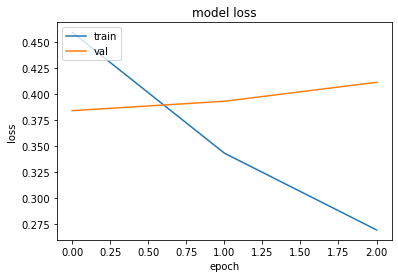

In [22]:
#Plot to show val_loss compared to train loss.
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Validation loss is decreasing with epoch. It does not appear that model is overfitting.

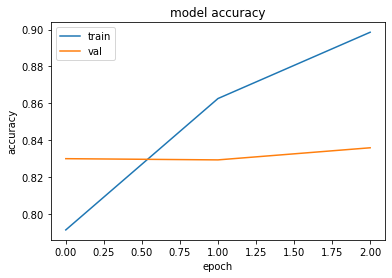

In [23]:
#Plot to show val_accuracy compared to train accuracy.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

Validation accuracy is increasing with epoch. It does not appear that model is overfitting.

# Make predictions

In [24]:
#predict
predictions = hypermodel.predict(X_test['input_ids'])
predictions_label = [np.argmax(x) for x in predictions[0]]
#print results
results = pd.DataFrame({'id': df_raw_test['id'], 'target': predictions_label})
results['target'] = results['target'].astype('int')
results.to_csv('predictions.csv', index=False)


102/102 [==============================] - 101s 980ms/step
